In [1]:
import sys
import pickle
sys.path.insert(0,'./')
import pyccl as ccl
from astropy.io import fits
# from importlib import reload

In [2]:
from distributed import LocalCluster
from dask.distributed import Client  
#http://distributed.readthedocs.io/en/latest/_modules/distributed/worker.html
LC=LocalCluster(n_workers=1,processes=False,memory_limit='25gb',threads_per_worker=10,memory_spill_fraction=.99,
               memory_monitor_interval='2000ms')
client=Client(LC)

In [3]:
client

Client Scheduler: inproc://136.152.250.183/23566/1 Dashboard: http://localhost:35817/status,Cluster Workers: 1 Cores: 10 Memory: 25.00 GB


In [4]:
from cov_3X2 import * #the main Skylens class
from lsst_utils import * #this defines functions to generate tracer bins, for LSST like, DES like, Kids like etc.

In [5]:
#only for python3
import importlib
reload=importlib.reload

# Lensing X Lensing Correlation function covariance

## Multiple redshift bins (Tomography)

In [6]:
# import cov_utils #useful for bug fixes.
# reload(cov_utils)
# from cov_utils import *

# import cov_3X2
# reload(cov_3X2)
# from cov_3X2 import *

from wigner_transform import *
from power_spectra import *

# import hankel_transform #hankel transform is now deprecated. Use wigner by default.
# reload(hankel_transform)
# from hankel_transform import *

In [7]:
cosmo_params={'h': 0.8433,
 'Omb': 0.062,
 'Omd': 0.2837-0.062,
 's8': 0.795431,
 'Om': 0.2837,
 'As': 1.685e-09,
'Ase9': 1.685,
 'mnu': 0.0,
 'Omk': 0.0,
 'tau': 0.06,
 'ns': 0.96859,
 'w': -1,
 'wa': 0,
 'Oml': 1.-0.2837}
#here is an example to call the power spectra class. the main cov_3X2 class does the same.
PS=Power_Spectra(cosmo_params=cosmo_params)
k,pk,s8=PS.camb_pk(z=[0],cosmo_params=cosmo_params,return_s8=True)
s8

0.7971166462048332

In [8]:
mnu=cosmo_h.m_nu*0
cosmo=cosmo.clone(m_nu=mnu,Ob0=cosmo_params['Omb'],Om0=cosmo_params['Om'])
cosmo_h=cosmo.clone(H0=100) #,m_nu=mnu,Ob0=cosmo_params['Omb'],Om0=cosmo_params['Om'])
ccl_cosmo = ccl.Cosmology(Omega_c=cosmo_params['Omd'], Omega_b=cosmo_params['Omb'], 
                      h=cosmo_params['h'], A_s=cosmo_params['As'], n_s=cosmo_params['ns'],)#m_nu=[0,0,0.06])
#ccl can be useful to test power spectra and correlation functions calculations.

In [9]:
cov_des=np.genfromtxt('../covariance_testing/data/DES-Y3//cosmolike_cov_Y3ish/cov_y3_mcal_emu_final.txt')
covG_des=np.genfromtxt('../covariance_testing/data/DES-Y3/cosmolike_cov_Y3ish/cov_y3_mcal_emu_final.txt') 
# covNG_shear=np.genfromtxt('/home/deep/repos/DESC_SRD/cov/Y10_shear_shear_covNG',) 

l_min0=20
l_max0=15000
nl0=20
l_bins=np.logspace(np.log10(l_min0),np.log10(l_max0),nl0+1)
lb=0.5*(l_bins[1:]+l_bins[:-1])

lb15=np.tile(lb,15)
x=lb15<3000
covG_shear=covG_des[:,2].reshape(900,900)[:400,:400] #10 X 2 X 20
cov_shear=cov_des[:,2].reshape(900,900)[:400,:400]

covG_ggl=covG_des[:,2].reshape(900,900)[400:800,400:800] #10 X 2 X 20
cov_ggl=cov_des[:,2].reshape(900,900)[400:800,400:800]

covG_gg=covG_des[:,2].reshape(900,900)[800:900,800:900] #10 X 2 X 20
cov_gg=cov_des[:,2].reshape(900,900)[800:900,800:900]


cov_des=cov_des[:,2].reshape(900,900)
covG_des=covG_des[:,2].reshape(900,900)
# covNG_shear=covNG_shear[x].T[x].T

x=lb<3000
lb=lb[x]
l_bins=l_bins[:16]

In [10]:
sigma_gamma=0.3944/sqrt(2.)  # shape noise

In [11]:
l_max=4e4
l_maxW=6e4 #lmax for the wigner transforms.. We need high l_max to reduce biases+ringing.
l_min=2
# l0=np.arange(l_min,l_maxW)   #np.arange(l_min,l_max)
l0=np.logspace(np.log10(l_min),np.log10(l_maxW),6.e3) #l values used in the wigner calculations. Code integrates over missing l assuming constant cl*wigner_mat.
# l0=np.sort(np.append(l0,np.logspace(np.log10(l_maxW),np.log10(l_maxW*10),1.e3)))
l0=np.unique(np.int32(l0))   #np.arange(l_min,l_max) #l are integers
# l0=np.unique(np.int32(np.logspace(np.log10(l_min),np.log10(l_maxW),4.e3)))   #np.arange(l_min,l_max)

In [12]:
#Setup lens redshift bins
source_f='../covariance_testing/data/DES-Y3//cosmolike_cov_Y3ish/lens.nz'
zmin=0
zmax=3.5

nl_bins=4  # Number of tomographic bins
zl_bins=DES_lens_bins(fname=source_f,l=[1])

In [13]:
#Setup source redshift bins
source_f='../covariance_testing/data/DES-Y3//cosmolike_cov_Y3ish/source.nz'
zmin=0
zmax=3.5

nbins=4  # Number of tomographic bins
zs_bins=DES_bins(fname=source_f,sigma_gamma=sigma_gamma,l=[1])

In [14]:
f_sky=5000./(4*np.pi/d2r**2)
# f_sky=4182./(4*np.pi/d2r**2)

In [15]:
f_sky*4*np.pi

1.5230870989335428

In [16]:
do_xi=True
bin_xi=True
do_cov=True #you can turn this to False if only data vectors are needed. Note that covariances are slow and should be computed only onece. When doing repeated calls, it is recommeneded to turn this to False.
bin_cl=False
th_min=2.5/60
th_max=250./60
n_th_bins=20

th_bins=np.logspace(np.log10(th_min),np.log10(th_max),n_th_bins+1) #these are theta bin edges

th=np.logspace(np.log10(th_min*0.98),np.log10(1),n_th_bins*30) #these theta values where xi/cov is evaluated and then binnned to th_bins.
th2=np.linspace(1,th_max*1.02,n_th_bins*30)
# th2=np.logspace(np.log10(1),np.log10(th_max),60*6)
th=np.unique(np.sort(np.append(th,th2))) # We are using some log-linear setup for th, I don't remember exactly why, but it had to do with converegence of the final binned results.
thb=np.sqrt(th_bins[1:]*th_bins[:-1])

In [17]:
use_window=False #to use windows, you will require large wigner_3j matrices which are computed and saved separately. For basic testing, it is recommended to leave it to False.
do_sample_variance=True
SSV_cov=False
tidal_SSV=True #only used when SSV_cov=True


In [18]:
power_spectra_kwargs={'cosmo':cosmo,'cosmo_params':cosmo_params,'pk_func':'camb_pk_too_many_z'}

In [19]:
corr_ggl=('shear','galaxy')
corr_gg=('galaxy','galaxy')
corr_ll=('shear','shear')

corrs=[corr_ll,corr_ggl,corr_gg] #this tells the code which correlations to compute.

In [20]:
#### Wigner Transform setup...
WT_L_kwargs={'l': l0,'theta': th*d2r,'m1_m2':[(2,2),(2,-2),(0,2),(2,0),(0,0)]}
%time WT_L=wigner_transform(**WT_L_kwargs) #get the wigner_tranform class. This converts harmonic space quantities to real space ones (full sky vversion of hankel transforms).

#intialize the main class.
XI_W_L= cov_3X2(zs_bins=zs_bins,l=l0,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,zg_bins=zl_bins,
                do_sample_variance=do_sample_variance,use_window=use_window,
                power_spectra_kwargs=power_spectra_kwargs,corrs=corrs,
               SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,do_xi=True,HT=WT_L,f_sky=f_sky,
               bin_xi=bin_xi,theta_bins=th_bins)#ns=np.inf)

CPU times: user 825 ms, sys: 800 ms, total: 1.62 s
Wall time: 27.8 s


./cov_utils.py:62: RuntimeWarning: invalid value encountered in true_divide
  Win0=2*jn(1,l_th)/l_th


In [21]:
gg_i=[(i,i) for i in np.arange(zl_bins['n_bins'])]
XI_W_L.stack_indxs[corr_gg]=gg_i
#we compute the correlation functions/power spectra, based on tracers and their bin combinations. There is corr_indxs, which defines all the correlations that need to be computed. In general you donot need to worry about it. 
# Then there is stack_indxs which tell defines the quantities that will be computed and then stacked into one long data vector and its covariance. The ordering of 'corrs' (input while intializing the XI_W_L) and stack_indxs can be changed
# to change the ordering in the stacked data vector. For ex. here we changed the stack indxs so that only the auto correlation of galaxy (lens) bins is returned and cross correlations are ignored.
# XI_W_L.stack_indxs

In [22]:
# %time xiHG=XI_H.xi_tomo()
# %time xiHG2=XI_H2.xi_tomo()
%time xiWG_L=XI_W_L.xi_tomo() #this setups up the compute graph. The graph (xiWG_L) is a dictionary, with xi, cov and stack keys.  
#xi and cov are dictionaries themselves that contain the graph for individual xi and covariance computes. See example below
#stack compute will return all xi and cov, stacked in order specified by order of corrs and stack_indxs.

added extra corr calc for covariance [('shear', 'shear'), ('shear', 'galaxy'), ('galaxy', 'galaxy'), ('galaxy', 'shear')]
Note: redshifts have been re-sorted (earliest first)
cl dict done
CPU times: user 8.63 s, sys: 211 ms, total: 8.85 s
Wall time: 4.98 s


/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


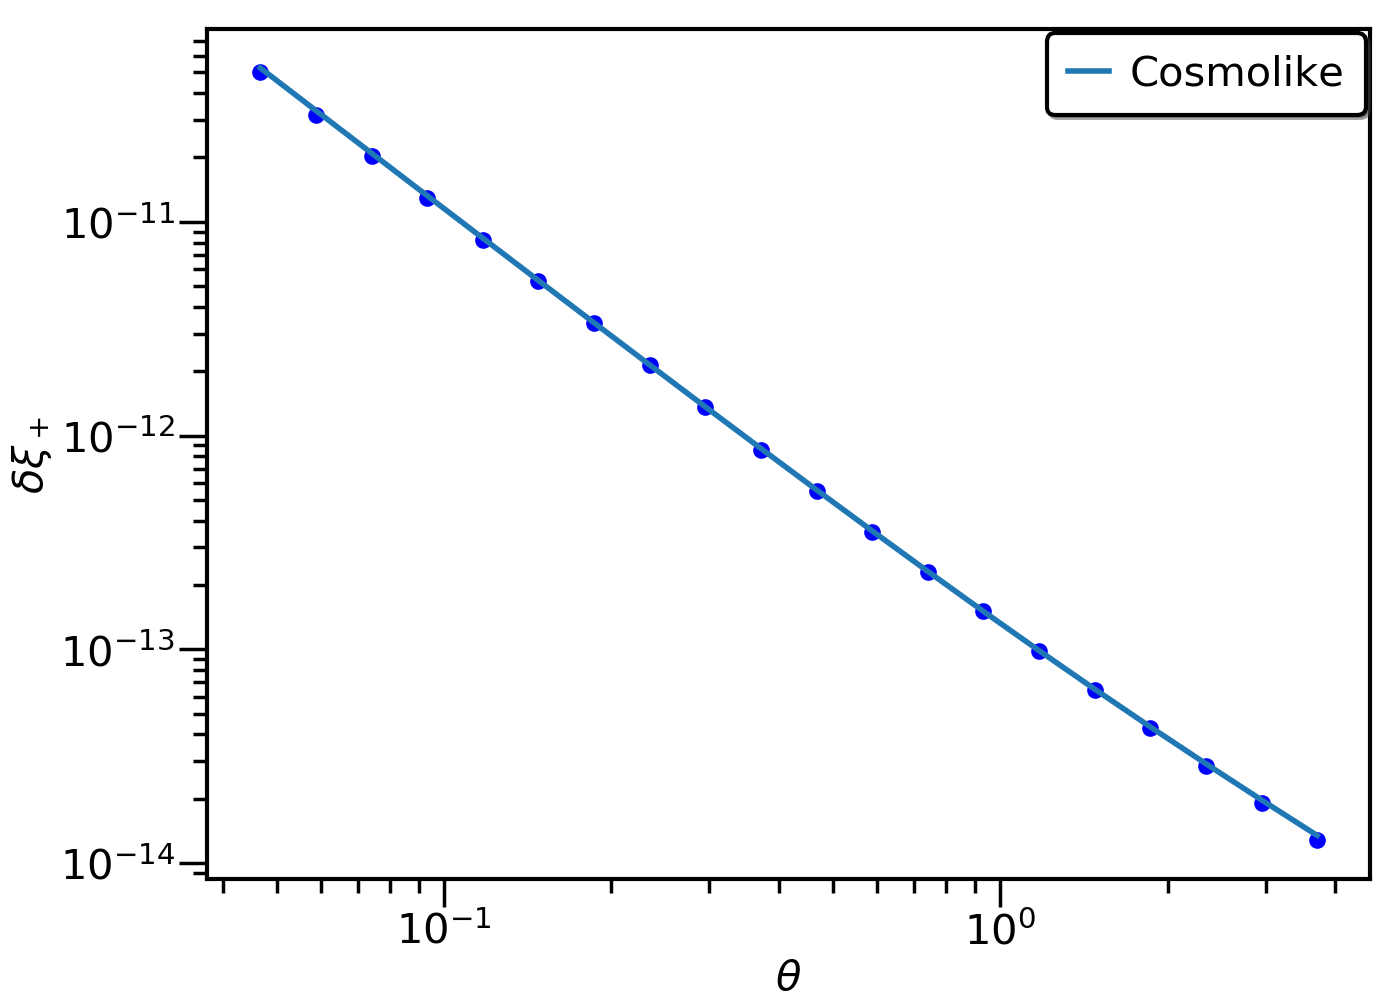

In [23]:
# plot(thb,np.diag(cov_shear/xiH['cov'])[:20])
# plot(thb,xiH['xi'][:20])
ii=0
i=ii*20
j=i+20
ii=0
sn=0#np.diag(cov_shear)[0]/thb**2*thb[0]**2
cc=xiWG_L['cov'][('shear','shear','shear','shear')][(2,2,2,2)][(ii,ii,ii,ii)].compute() #this compute only 1 covariance matrix. 
#Shear autocorrelation, hence 4 shears and for bin 1, hence all bin indxs are ii. '2,2' corresponds to xi+, '2,-2' will be xi- (these are related to tracer spins). 
#You can change these to compute various auto/cross covariances. More examples below.

plot(thb,np.diag(cc['final']),'bo')
# plot(thb,np.diag(xiW_L['cov'])[i:j],'bo')
plot(thb,np.diag(cov_shear)[i:j],label='Cosmolike')
# plot(thb,np.diag(cov_shear)[0]/thb**2*thb[0]**2)
xscale('log')
yscale('log')
xlabel(r'$\theta$')
ylabel(r'$\delta \xi_+$')
legend()

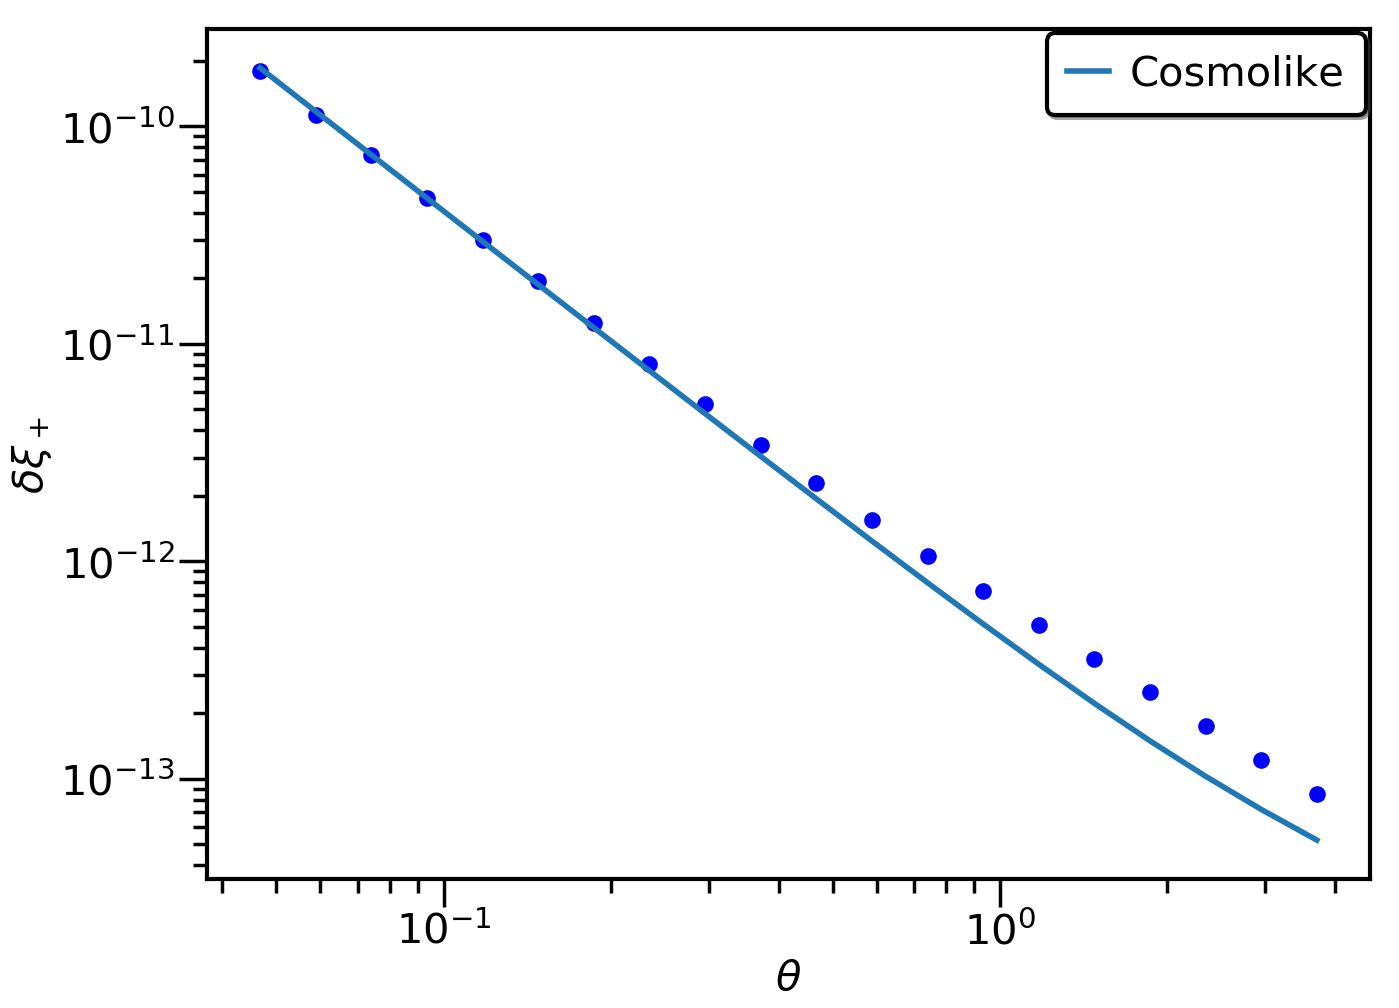

In [24]:
# plot(thb,np.diag(cov_shear/xiH['cov'])[:20])
# plot(thb,xiH['xi'][:20])
ii=19
i=ii*20
j=i+20
ii=3
sn=0#np.diag(cov_shear)[0]/thb**2*thb[0]**2
cc=xiWG_L['cov'][('shear','shear','shear','shear')][(2,2,2,2)][(ii,ii,ii,ii)].compute()

plot(thb,np.diag(cc['final']),'bo')
# plot(thb,np.diag(xiW_L['cov'])[i:j],'bo')
plot(thb,np.diag(cov_shear)[i:j],label='Cosmolike')
# plot(thb,np.diag(cov_shear)[0]/thb**2*thb[0]**2)
xscale('log')
yscale('log')
xlabel(r'$\theta$')
ylabel(r'$\delta \xi_+$')
legend()

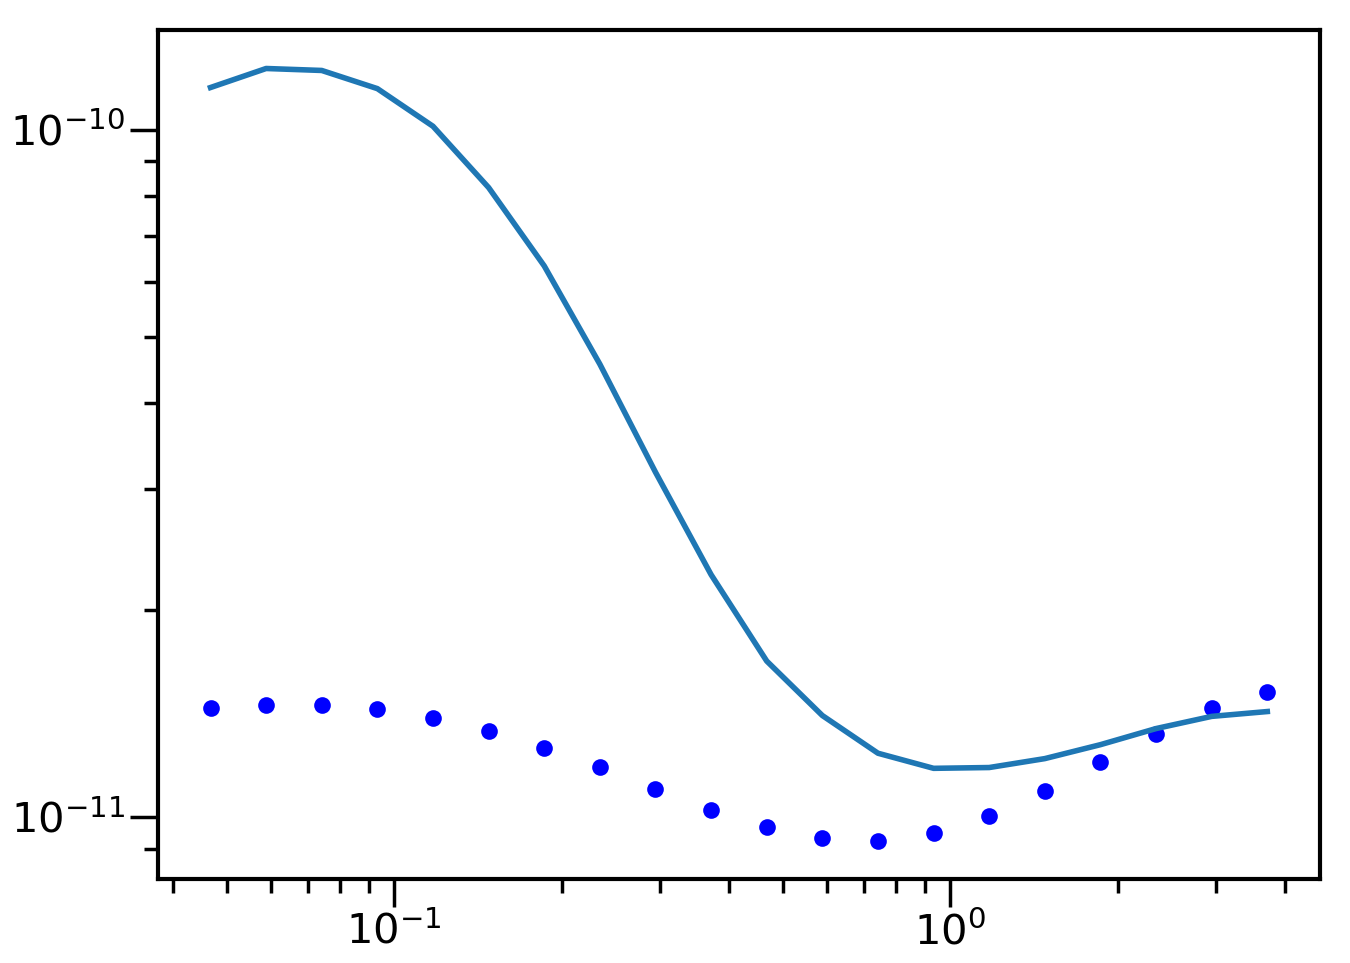

In [25]:
# plot(thb,np.diag(cov_shear/xiH['cov'])[:20])
# plot(thb,xiH['xi'][:20])
ii=0
i=ii*20
ii2=1
j=ii2*20

cc2=cov_ggl[i:i+20,j:j+20]
sn=np.diag(cc2)[0]/thb**2*thb[0]**2

cc=xiWG_L['cov'][('shear','galaxy','shear','galaxy')][(2,0,2,0)][(0,0,1,0)].compute() # this is cross coavariance between two GGL calculations (GGL is '2 0', galaxy spin is 0). galaxy bin is 0 for both, but shear bin is different (0 and 1) 
cc3=xiWG_L['cov'][('shear','galaxy','shear','galaxy')][(2,0,2,0)][(0,0,0,0)].compute()
# cc=xiWG_L['cov'][('galaxy','shear','galaxy','shear')][(0,2,0,2)][(0,0,0,0)].compute()

# plot(thb,np.diag(xiW_L['cov'])[i:j],'bo')
plot(thb,np.diag(cc['final']),'bo')
# plot(thb,sn,':')
plot(thb,np.diag(cc2))
# plot(thb,np.diag(cc3['final']),'ro')
# plot(thb,np.diag(cov_shear)[0]/thb**2*thb[0]**2)
xscale('log')
yscale('log')
#FIXME: This plot is shows some discrepancy, not sure why. 

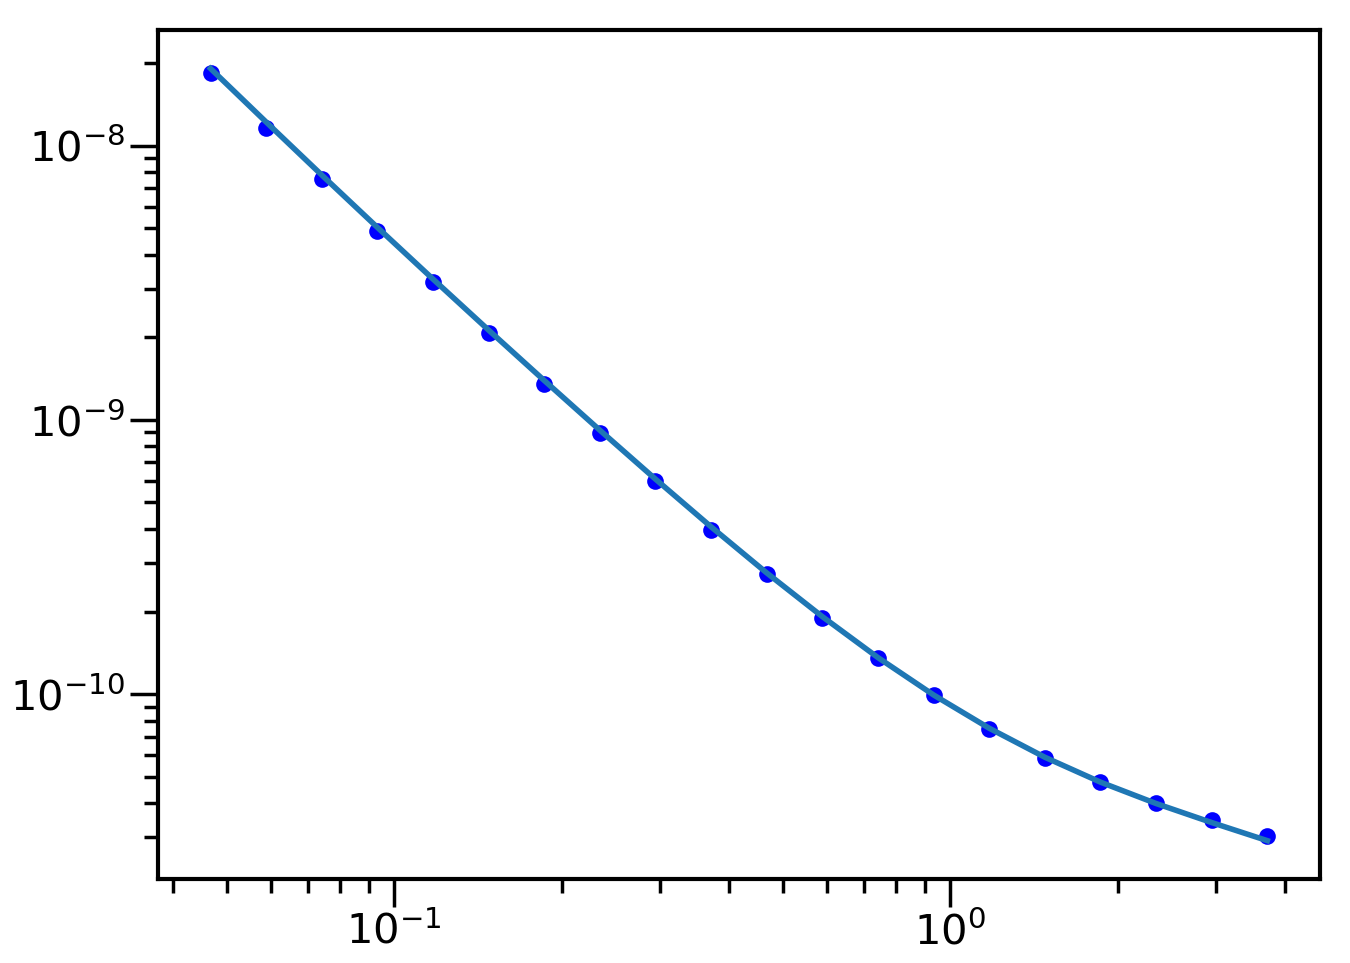

In [26]:
# plot(thb,np.diag(cov_shear/xiH['cov'])[:20])
# plot(thb,xiH['xi'][:20])
ii=0
i=ii*20
ii2=0
j=ii2*20

cc2=cov_ggl[i:i+20,j:j+20]
sn=np.diag(cc2)[0]/thb**2*thb[0]**2

cc=xiWG_L['cov'][('shear','galaxy','shear','galaxy')][(2,0,2,0)][(0,0,0,0)].compute()


plot(thb,np.diag(cc['final']),'bo')
# plot(thb,sn,':')
plot(thb,np.diag(cov_ggl)[i:i+20])
# plot(thb,np.diag(cc3['final']),'ro')
# plot(thb,np.diag(cov_shear)[0]/thb**2*thb[0]**2)
xscale('log')
yscale('log')

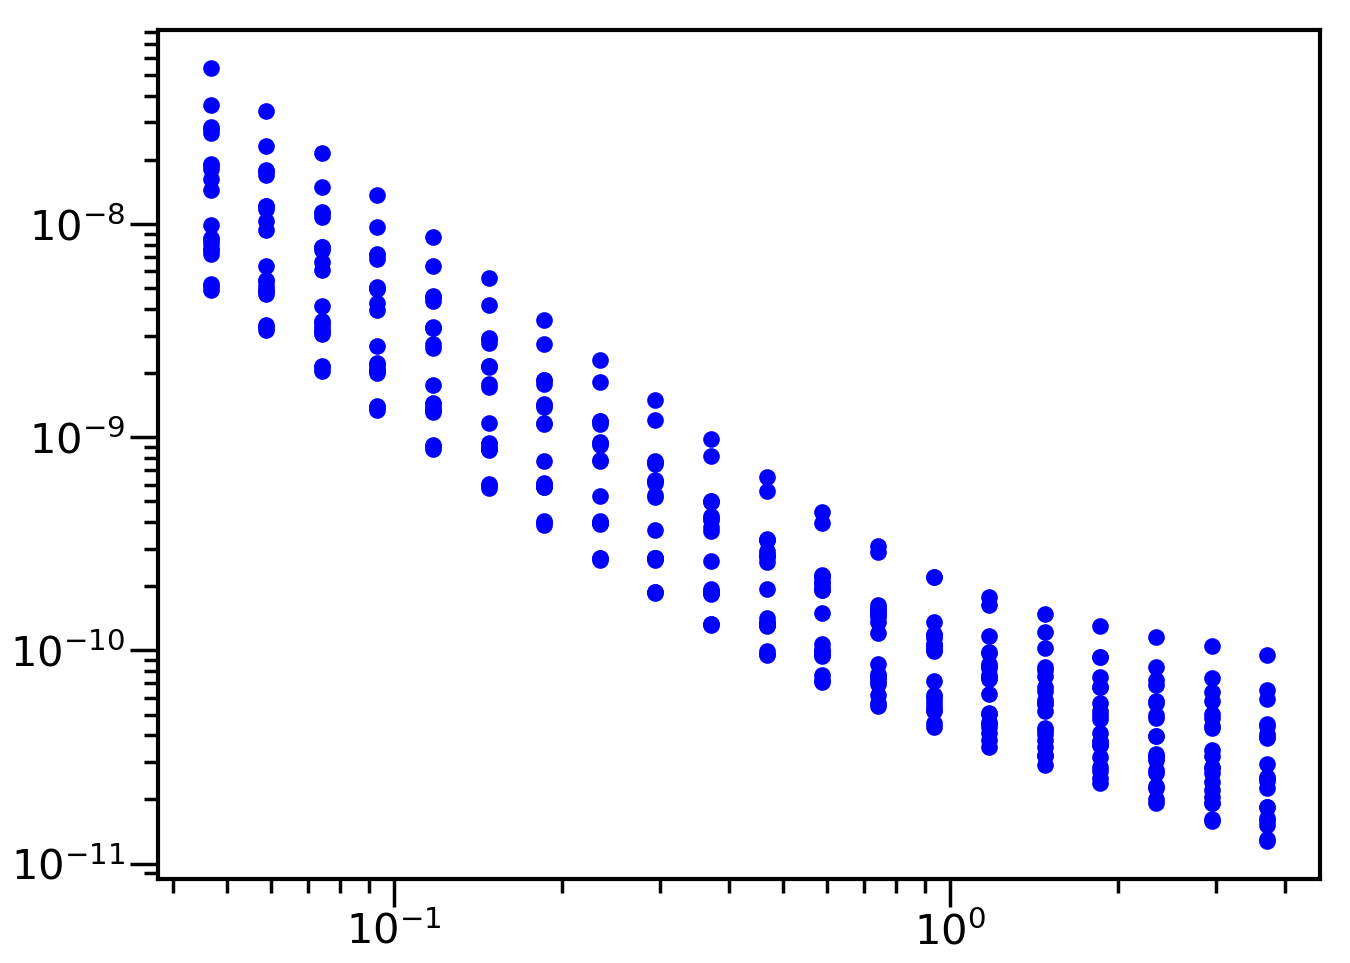

In [27]:
plot(np.tile(thb,20),np.diag(cov_ggl),'bo')
xscale('log')
yscale('log')

In [ ]:
%time xiW_L=xiWG_L['stack'].compute() # this will compute the full stack. Note that covariance takes a while (~40 mins on an 8cpu machine).

In [ ]:
f=1
# cov_xiH_inv=np.linalg.inv(xiH['cov']*f)
# print (np.sqrt(np.dot(xiH['xi'],np.dot(cov_xiH_inv,xiH['xi']))))

cov_xiWL_inv=np.linalg.inv(xiW_L['cov']*f)
print (np.sqrt(np.dot(xiW_L['xi'],np.dot(cov_xiWL_inv,xiW_L['xi']))))

In [ ]:
cc=XI_W_L.cov_utils
corrW=cc.corr_matrix(xiW_L['cov'])
pcolor(corrW,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
title('Wigner')
# hlines(60,0,120)
# vlines(60,0,120)
xticks([])
yticks([])


colorbar()
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

In [ ]:
cc=XI_W_L.cov_utils
corr_shear2=cc.corr_matrix(covG_ggl)
pcolor(corr_shear2,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
title('Cosmolike')
# hlines(60,0,120)
# vlines(60,0,120)
xticks([])
yticks([])


colorbar()
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

In [ ]:
cc=XI_W_L.cov_utils
corr_shear=cc.corr_matrix(covG_des)
pcolor(corr_shear,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
title('Cosmolike')
# hlines(60,0,120)
# vlines(60,0,120)
xticks([])
yticks([])


colorbar()
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

In [ ]:
pcolor(corr_shear-corrW,vmin=-1,vmax=1,cmap='seismic')
colorbar()
xticks([])
yticks([])

In [ ]:
pcolor(cov_des/xiW_L['cov']-1,cmap='seismic',vmin=-1,vmax=1,)
colorbar()

In [ ]:
plot(thb,XI_W_L.xi_bin_utils[(2,2)]['norm']/thb**2)
xscale('log')
# yscale('log')

In [ ]:
cov_test=np.genfromtxt('shape_noise_cov.dat')
cov_test2=np.genfromtxt('shape_noise_diag.dat')

In [ ]:
# plot(thb,np.diag(cov_shear/xiH['cov'])[:20])
# plot(thb,xiH['xi'][:20])
ii=0
i=ii*20
j=i+20
sn=np.diag(cov_shear)[0]/thb**2*thb[0]**2
# NN=np.diag(xiH['cov'])[i:j]-sn/2.
# plot(thb,np.diag(xiH['cov'])[i:j],'--')
# plot(thb,np.diag(xiH2['cov'])[i:j],'--')
plot(thb,np.diag(xiW_L['cov'])[i:j],'bo')
# plot(thb,np.diag(cov_test),':')
# plot(thb,cov_test2,':')
# plot(thb,sn,':')
plot(thb,np.diag(cov_shear)[i:j])
# plot(thb,np.diag(cov_shear)[0]/thb**2*thb[0]**2)
xscale('log')
yscale('log')

In [ ]:
# plot(thb,np.diag(cov_shear/xiH['cov'])[:20])
# plot(thb,xiH['xi'][:20])
ii=1
i=ii*20
j=i+20

cc=xiWG_L['cov'][('galaxy','galaxy','galaxy','galaxy')][(0,0,0,0)][(ii,ii,ii,ii)].compute()

sn=np.diag(cov_gg)[0]/thb**2*thb[0]**2
# plot(thb,np.diag(xiW_L['cov'])[i:j],'bo')
plot(thb,np.diag(cc['final']),'bo')
# plot(thb,sn,':')
plot(thb,np.diag(cov_gg)[i:j])
# plot(thb,np.diag(cov_shear)[0]/thb**2*thb[0]**2)
xscale('log')
yscale('log')

In [ ]:
# plot(thb,np.diag(cov_shear/xiH['cov'])[:20])
# plot(thb,xiH['xi'][:20])
ii=4
i=ii*20
ii2=0
j=ii2*20

cc2=cov_ggl[i:i+20,j:j+20]
sn=np.diag(cc2)[0]/thb**2*thb[0]**2

cc=xiWG_L['cov'][('shear','galaxy','shear','galaxy')][(2,0,2,0)][(0,0,0,1)].compute()
# cc=xiWG_L['cov'][('galaxy','shear','galaxy','shear')][(0,2,0,2)][(0,0,0,0)].compute()

# plot(thb,np.diag(xiW_L['cov'])[i:j],'bo')
plot(thb,np.diag(cc['final']),'bo')
# plot(thb,sn,':')
plot(thb,np.diag(cc2))
# plot(thb,np.diag(cov_shear)[0]/thb**2*thb[0]**2)
xscale('log')
yscale('log')

In [ ]:
XI_W_L.galaxy_utils.nz_F

In [ ]:
corrs_t=('shear','galaxy','shear','galaxy')
indxs_t=(0,0,0,0)
XI_W_L.cov_utils.get_SN(XI_W_L.SN,corrs_t,indxs_t)

In [ ]:
# plot(thb,np.diag(cov_shear/xiH['cov'])[:20])
# plot(thb,xiH['xi'][:20])
ii=0
i=ii*20
ii2=1
j=ii2*20

cc2=cov_ggl[i:i+20,j:j+20]
sn=np.diag(cc2)[0]/thb**2*thb[0]**2

cc=xiWG_L['cov'][('shear','galaxy','shear','galaxy')][(2,0,2,0)][(0,0,1,0)].compute()
cc3=xiWG_L['cov'][('shear','galaxy','shear','galaxy')][(2,0,2,0)][(0,0,0,0)].compute()
# cc=xiWG_L['cov'][('galaxy','shear','galaxy','shear')][(0,2,0,2)][(0,0,0,0)].compute()

# plot(thb,np.diag(xiW_L['cov'])[i:j],'bo')
plot(thb,np.diag(cc['final']),'bo')
# plot(thb,sn,':')
plot(thb,np.diag(cc2))
# plot(thb,np.diag(cc3['final']),'ro')
# plot(thb,np.diag(cov_shear)[0]/thb**2*thb[0]**2)
xscale('log')
yscale('log')

In [ ]:
plot(thb,np.diag(xiW_L['cov'])[i:j]-cov_test2,'--')
plot(thb,np.diag(xiH['cov'])[i:j]-cov_test2,'--')
plot(thb,(np.diag(cov_shear)[i:j]-cov_test2)*1.2)

xscale('log')
yscale('log')

In [ ]:
plot(thb,np.diag(xiW_L['cov'])[i:j],':')
plot(thb,np.diag(cov_test),':')
plot(thb,cov_test2,':')

xscale('log')
yscale('log')

In [ ]:
plot(thb,np.diag(cov_shear/xiH['cov'])[:20])
plot(thb,np.diag(cov_shear/xiW_L['cov'])[:20])
xscale('log')
# yscale('log')

In [ ]:
d2r/60

In [ ]:
XI_H.z_bins['shear'][0]['nz']

In [ ]:
XI_H.SN

In [ ]:
ns=XI_H.z_bins['shear'][0]['nz']*3600/d2r**2
sigma_gamma**2/ns

In [ ]:
XI_H.z_bins['shear'][0]['SN']

In [ ]:
plot(np.diag(xiW_L['cov']/xiH['cov'])[:20])
ylim(0.9,1.1)

In [ ]:
#comparisons with CCL below.

In [ ]:
for i in np.arange(nbins):
    for j in np.arange(i,nbins):
        lens1 = ccl.ClTracerLensing(ccl_cosmo, False, z=zs_bins[i]['z'], n=zs_bins[i]['pz'])
        lens2 = ccl.ClTracerLensing(ccl_cosmo, False, z=zs_bins[j]['z'], n=zs_bins[j]['pz'])
        cls = ccl.angular_cl(ccl_cosmo, lens1, lens2, CL.l)
        plot(CL.l,clG['cl']['cl'][corr][(i,j)].compute()/cls,label=(i,j))
        xscale('log')
#         yscale('log')
        xlabel(r'$\ell$')
        ylabel(r'$C_\ell$')
        hlines(1,2,1000)
        legend()
        ylim(0.9,1.1)
    show()

In [ ]:
m1m2=(2,2)
cp=['r','b','g','y']#sns.color_pallete()
for i in np.arange(nbins):
    for j in np.arange(i,nbins):
        lens1 = ccl.ClTracerLensing(ccl_cosmo, False, z=zs_bins[i]['z'], n=zs_bins[i]['pz'])
        lens2 = ccl.ClTracerLensing(ccl_cosmo, False, z=zs_bins[j]['z'], n=zs_bins[j]['pz'])
        cls = ccl.angular_cl(ccl_cosmo, lens1, lens2, CL.l)
        cls_b=CL.binning.bin_1d(xi=cls,bin_utils=CL.cl_bin_utils)
        plot(lb,cls_b,color=cp[j],ls=':')
        
    xscale('log')
    yscale('log')
    xlabel(r'$\ell$')
    ylabel(r'$C_\ell$')
    legend(ncol=3)
    show()